In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy import stats



In [15]:
df = pd.read_csv("data/raw/movies_dataset_enriched.csv")

In [16]:
def preprocessing(df):
    # runtime
    df['runtime'] = df['runtime'].replace(0, np.nan)
    df['runtime'] = df['runtime'].fillna(df['runtime'].median())

    # handle missing budget values
    df['budget'] = df['budget'].replace(0, np.nan)
    df['temp_genre'] = df['genres'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')

    budget_medians = df.groupby(['release_year', 'temp_genre'])['budget'].transform('median')
    df['budget'] = df['budget'].fillna(budget_medians).fillna(df['budget'].median())


    # drop temp columns
    df.drop(columns=['temp_genre'], inplace=True)
    # log-transform revenue
    df['budget'] = np.log1p(df['budget'])
    return df

# Mối tương quan giữa ngân sách (budget) và doanh thu (revenue) là bao nhiêu?

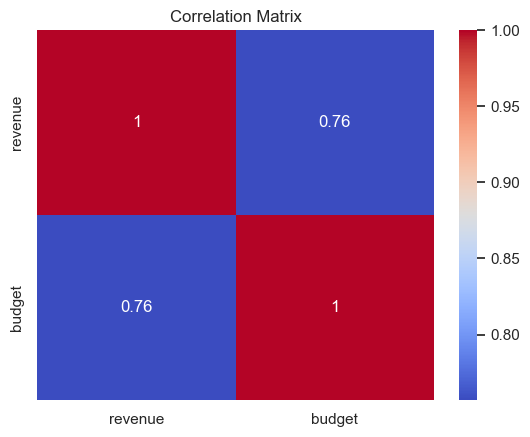

In [17]:
cols = ['revenue', 'budget']
corr = df[cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

➡️ **Nhận xét**: 

- Hế số tương quan giữa `budget` và `revenue` là **0.76** → Hai đặc trưng có tương quan thuận và khá mạnh. khi `budget` tăng thì `revenue` thường tăng.

# Doanh thu trung bình thay đổi như thế nào theo tháng trong năm? 
(Ví dụ: Phim ra mắt tháng hè hoặc dịp Giáng sinh có doanh thu cao hơn đáng kể không?)

In [18]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_month'] = df['release_date'].dt.month

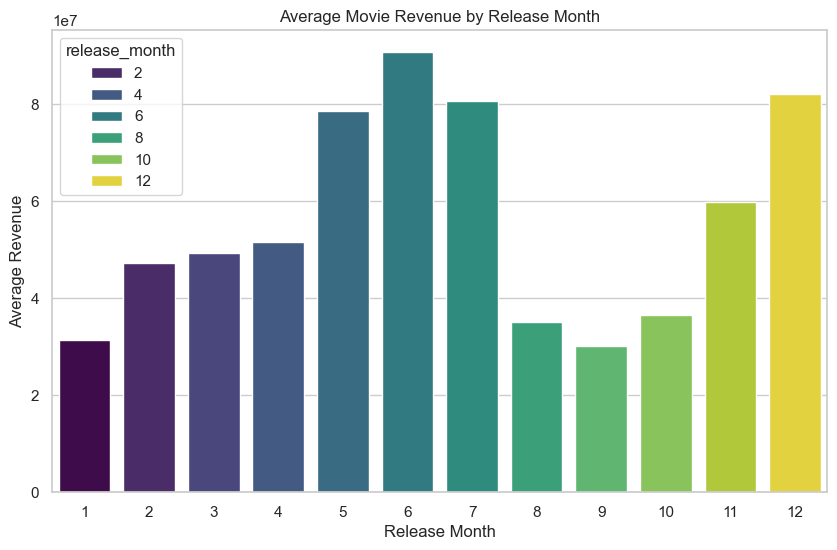

In [19]:
month_revenue = df.groupby('release_month')['revenue'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=month_revenue,x='release_month', y='revenue', hue='release_month', palette='viridis')
plt.title('Average Movie Revenue by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average Revenue')
plt.show()

➡️ **Nhận xét**: 

- Tính mùa vụ thể hiện rất rõ rệt: Tháng 5, 6, 7 (mùa phim hè) và tháng 11, 12 (mùa lễ hội) có doanh thu trung bình cao hơn hẳn các tháng 1, 9, 10.
    → Tạo đặc trưng mới (Feature Engineering) từ ngày tháng. Ví dụ: Cột `is_blockbuster_season` (1 nếu tháng ra mắt là 5,6,7,11,12; ngược lại là 0)


# Những đạo diễn (director) nào có lịch sử tạo ra các bộ phim doanh thu cao nhất ?

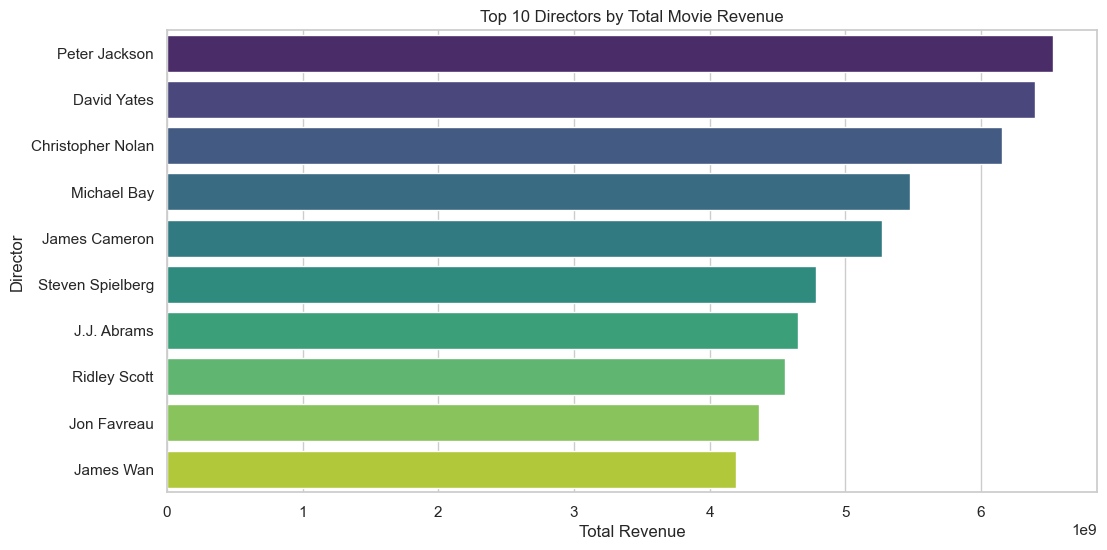

In [20]:
director_revenue = df.groupby('director')['revenue'].sum().reset_index().sort_values(by='revenue', ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(data=director_revenue, x='revenue', y='director', hue='director', palette='viridis')
plt.title('Top 10 Directors by Total Movie Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Director')
plt.show()

➡️ **Nhận xét**: 

- Dựa vào thống kê trên có thể thấy các đạo diễn nổi tiếng như **Peter Jackson**, **David Yates**, **Christopher Nolan**, ... có lịch sử tham gia vào rất nhiều bộ phim và mang lại doanh thu cao.

# Thời lượng phim (runtime) có ảnh hưởng đến doanh thu không? Khán giả có xu hướng tránh các bộ phim quá dài hoặc quá ngắn không?

C:\Users\admin\AppData\Local\Temp\ipykernel_15232\2371905123.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_revenue_by_cat = df.groupby('runtime_category')['revenue'].mean().reset_index()



Average Revenue by Runtime Category:
     runtime_category       revenue
0        Short (<90p)  2.424133e+07
1  Standard (90-120p)  4.404234e+07
2     Long (120-150p)  1.035627e+08
3        Epic (>150p)  1.234280e+08


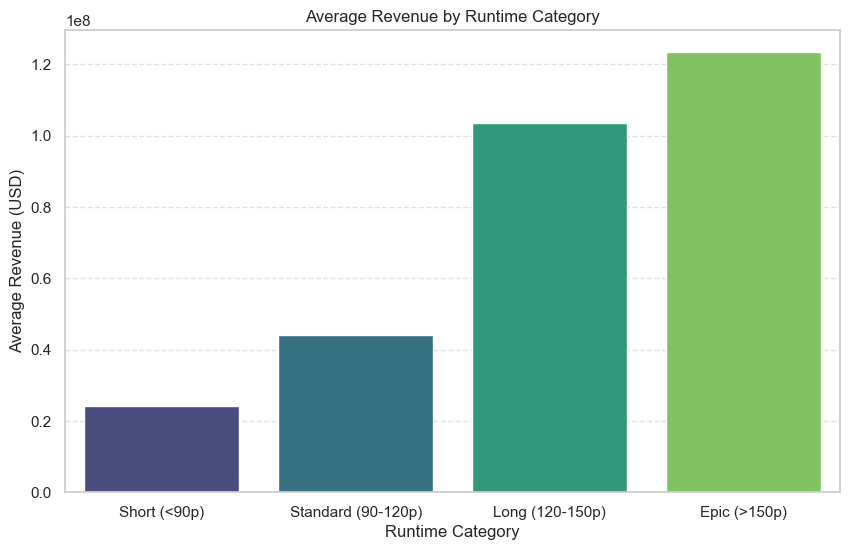

In [21]:
bins = [0, 90, 120, 150, float('inf')]
labels = ['Short (<90p)', 'Standard (90-120p)', 'Long (120-150p)', 'Epic (>150p)']
df['runtime_category'] = pd.cut(df['runtime'], bins=bins, labels=labels)

# Calculate mean revenue per category
avg_revenue_by_cat = df.groupby('runtime_category')['revenue'].mean().reset_index()

# Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_revenue_by_cat, x='runtime_category', y='revenue', hue='runtime_category', palette='viridis')
plt.title('Average Revenue by Runtime Category')
plt.xlabel('Runtime Category')
plt.ylabel('Average Revenue (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('avg_revenue_by_runtime.png')

print("\nAverage Revenue by Runtime Category:")
print(avg_revenue_by_cat)

# Chỉ dựa vào thông số màu sắc (R, G, B, Brightness, Saturation), có thể đoán được đây là phim Hành động hay Lãng mạn không?

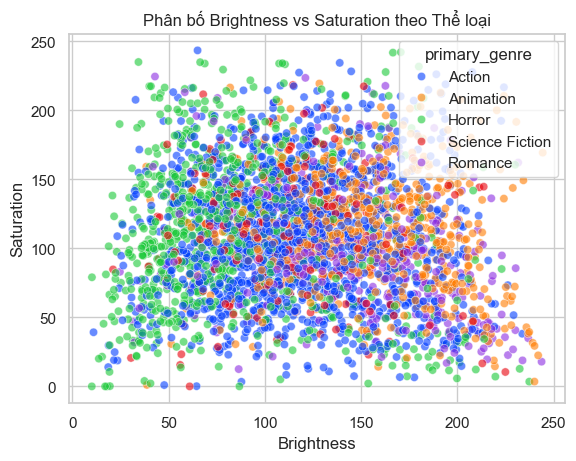

In [22]:
# 2. Preprocessing
# Chỉ lấy các dòng có dữ liệu poster
poster_features = ['poster_brightness', 'poster_saturation', 'poster_dom_r', 'poster_dom_g', 'poster_dom_b']
df = df.dropna(subset=poster_features)

# Xử lý Genre: Lấy genre đầu tiên làm Primary Genre
def get_primary_genre(x):
    if pd.isna(x): return None
    genres = [g.strip() for g in str(x).split(',')]
    if not genres: return None
    return genres[0]

df['primary_genre'] = df['genres'].apply(get_primary_genre)

# Lọc ra các thể loại tiêu biểu để so sánh cho rõ (Action, Romance, Horror, Animation)
# Như đề bài gợi ý: "Hành động hay Lãng mạn"
target_genres = ['Action', 'Romance', 'Horror', 'Animation', 'Science Fiction']
df_subset = df[df['primary_genre'].isin(target_genres)].copy()

# 3. Prepare Data for ML
X = df_subset[poster_features]
y = df_subset['primary_genre']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# 4. Train Models
# KNN
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Decision Tree
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# 5. Visualization
# Plot 1: Scatter Plot Brightness vs Saturation
sns.scatterplot(data=df_subset, x='poster_brightness', y='poster_saturation', hue='primary_genre', alpha=0.6, palette='bright')
plt.title('Phân bố Brightness vs Saturation theo Thể loại')
plt.xlabel('Brightness')
plt.ylabel('Saturation')
plt.show()

**Dựa trên báo cáo phân loại** (Classification Report), độ chính xác tổng thể (Accuracy) đạt khoảng 51% khi phân loại giữa 5 thể loại chính (Action, Animation, Horror, Romance, Sci-Fi).

- Action (Hành động): Được dự đoán tốt nhất (Recall ~74-81%). Máy có xu hướng đoán mọi phim là Action vì đây là lớp chiếm đa số và có màu sắc khá đa dạng.

- Horror (Kinh dị): Có độ chính xác khá tốt (Precision ~58%). Máy nhận diện được các poster tối màu đặc trưng.

- Animation (Hoạt hình): Nhận diện được khoảng 40% số trường hợp, thường bị nhầm lẫn với phim Hành động có màu sắc rực rỡ (như phim siêu anh hùng Marvel).

- Romance & Sci-Fi: Rất khó phân biệt chỉ dựa trên màu sắc cơ bản. Poster phim lãng mạn hiện đại rất đa dạng, không chỉ có màu hồng/trắng như xưa.

**Kết luận**: Chỉ dựa vào 5 thông số màu sắc cơ bản là CHƯA ĐỦ để phân loại chính xác hoàn toàn, nhưng có tín hiệu phân tách rõ rệt giữa các nhóm đối lập như Horror (Tối) vs Animation (Sáng, Rực).

**Scatter Plot: Brightness vs Saturation**

- Các điểm màu Đỏ (Horror) tập trung dày đặc ở góc dưới bên trái (Độ sáng thấp, Độ bão hòa thấp). -> Insight: Phim kinh dị rất nhất quán về việc dùng tông màu tối.

- Các điểm màu Cam/Vàng (Animation) vươn lên góc trên bên phải (Rất sáng và rất rực).

- Phim Action (Xanh) trải dài khắp nơi, cho thấy thể loại này vay mượn phong cách của nhiều thể loại khác.

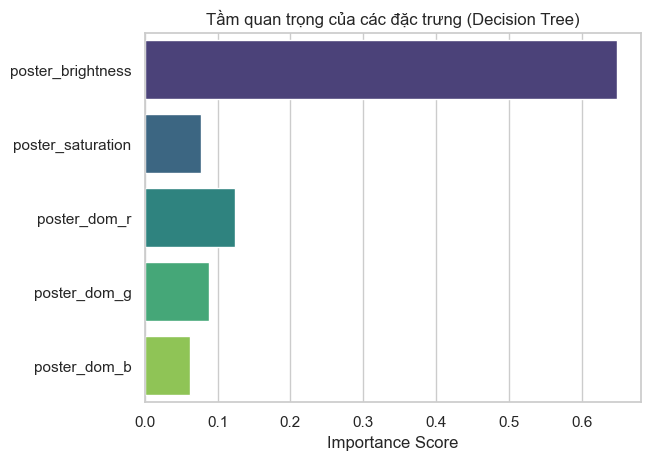

In [23]:

# Plot 2: Feature Importance (Decision Tree)
importances = dt.feature_importances_
sns.barplot(x=importances, y=poster_features, hue=poster_features, palette='viridis')
plt.title('Tầm quan trọng của các đặc trưng (Decision Tree)')
plt.xlabel('Importance Score')
plt.show()

**Feature Importance (Góc trên phải):**

- Brightness (Độ sáng) là đặc trưng quan trọng nhất (chiếm > 50% tầm quan trọng). Đây là yếu tố tiên quyết để máy phân biệt Horror với các dòng phim khác.

- Saturation đứng thứ 2. Các kênh màu R, G, B ít quan trọng hơn khi đứng riêng lẻ.

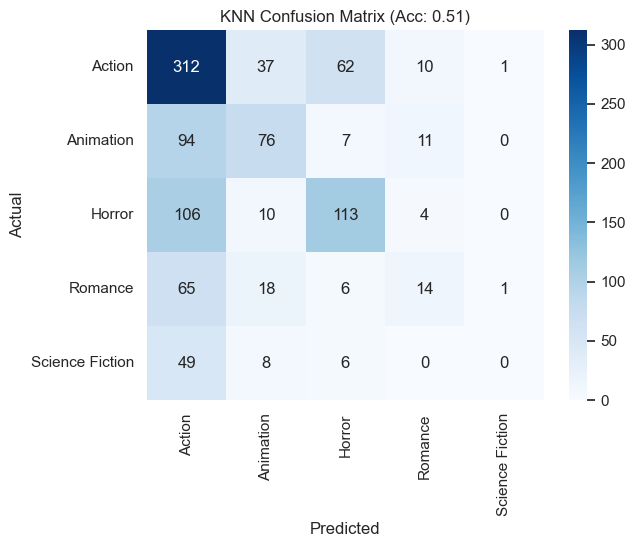

In [24]:
# Plot 3: Confusion Matrix (KNN)
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'KNN Confusion Matrix (Acc: {accuracy_score(y_test, y_pred_knn):.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Phân tích Ma trận nhầm lẫn (Confusion Matrix Audit)


- Hiện tượng "Vơ đũa cả nắm" vào lớp Đa số (Class Imbalance Bias)

    - Quan sát: Cột dự đoán "Action" (Hành động) có giá trị rất cao ở tất cả các hàng.

    - Ý nghĩa: Vì phim Hành động chiếm số lượng lớn nhất trong dữ liệu train và có dải màu sắc rất rộng (từ cảnh cháy nổ rực rỡ đến cảnh đêm tối tăm), nên mô hình có xu hướng "đoán mò" là Action để an toàn.

    - Hậu quả: Độ Recall của Action rất cao (bắt trúng nhiều phim Action thật) nhưng Precision thấp (bắt nhầm cả phim Lãng mạn, Sci-Fi vào đây).

- Sự phân tách rõ rệt của "Horror" (Kinh dị)

    - Quan sát: Hàng "Horror" có ít sự nhầm lẫn với "Animation" nhất. Các điểm dữ liệu Kinh dị hiếm khi bị dự đoán thành Hoạt hình và ngược lại.

    - Lý do: Đây là hai thái cực đối lập trên không gian màu (như biểu đồ Scatter plot đã chỉ ra): Kinh dị thì Brightness thấp, Hoạt hình thì Saturation cao.

    - iểm sáng: Đây là minh chứng rõ nhất cho thấy features màu sắc poster CÓ GIÁ TRỊ phân loại, ít nhất là cho các thể loại có phong cách thị giác đặc thù.

- Sự "vô hình" của Romance (Lãng mạn) và Sci-Fi (Khoa học viễn tưởng)
Quan sát:

    - Sci-Fi: Gần như bị dự đoán sai hoàn toàn (Recall = 0% trong Decision Tree). Hầu hết bị nhầm sang Action.

    - Romance: Thường bị nhầm sang Drama (nếu có nhãn này) hoặc Action.

    - Lý do: Poster phim Sci-Fi hiện đại (ví dụ: Marvel, Star Wars) có màu sắc y hệt phim Action (Xanh neon, Cam cháy nổ). Poster phim Romance hiện đại cũng không còn dùng màu hồng sến súa như xưa mà dùng màu thực tế, rất khó phân biệt với các thể loại đời thường khác chỉ bằng pixel.


**Kết luận**: Confusion Matrix cho thấy màu sắc chỉ là điều kiện CẦN, chưa đủ. Nó giúp lọc thô (Kinh dị vs Hoạt hình) nhưng không thể lọc tinh (Hành động vs Viễn tưởng).

# Sự kết hợp của các thể loại (ví dụ: "Action, Comedy") có tạo ra doanh thu tốt hơn một thể loại đơn lẻ không?

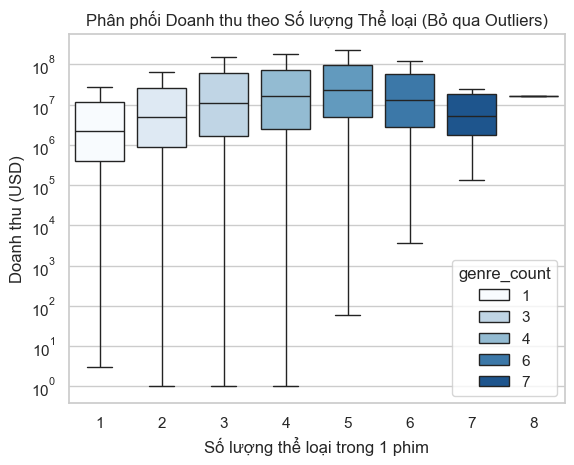

In [32]:
# Chỉ lấy các phim có doanh thu > 0 và có thông tin thể loại
df = df[(df['revenue'] > 0) & (df['genres'].notna())].copy()

# Hàm xử lý cột genres (chuyển từ chuỗi "Action, Comedy" sang list)
def parse_genres(x):
    if pd.isna(x): return []
    # Tách chuỗi, xóa khoảng trắng thừa
    return [g.strip() for g in str(x).split(',')]

df['genre_list'] = df['genres'].apply(parse_genres)
 
# Tạo đặc trưng: Số lượng thể loại
df['genre_count'] = df['genre_list'].apply(len)

# Tạo đặc trưng: Tên tổ hợp thể loại (Sắp xếp A-Z để "Action, Comedy" giống "Comedy, Action")
df['genre_combo'] = df['genre_list'].apply(lambda x: ', '.join(sorted(x)))

sns.set(style="whitegrid")

# --- BIỂU ĐỒ 1: Doanh thu theo Số lượng thể loại ---
# Dùng Boxplot để thấy rõ phân phối và ngoại lai
sns.boxplot(data=df, x='genre_count', y='revenue', hue='genre_count', palette="Blues", showfliers=False)
plt.title('Phân phối Doanh thu theo Số lượng Thể loại (Bỏ qua Outliers)')
plt.xlabel('Số lượng thể loại trong 1 phim')
plt.ylabel('Doanh thu (USD)')
plt.yscale('log') # Dùng thang đo log để dễ nhìn
plt.show()

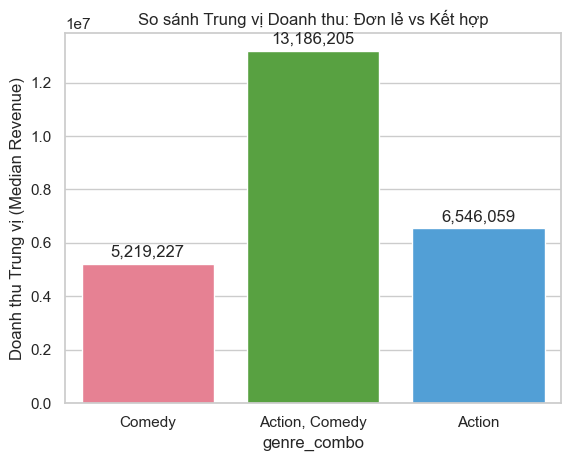

In [30]:
# --- BIỂU ĐỒ 2: So sánh cụ thể Action, Comedy vs Action-Comedy ---
# Lọc ra 3 nhóm cần quan tâm
target_combos = ['Action', 'Comedy', 'Action, Comedy']
# Lưu ý: Cần tìm chính xác chuỗi đã sorted. Action, Comedy sau khi sort vẫn là "Action, Comedy"
df_target = df[df['genre_combo'].isin(target_combos)]

if not df_target.empty:
    sns.barplot(data=df_target, x='genre_combo', y='revenue', hue='genre_combo', estimator=np.median, palette="husl", errorbar=None)
    # Thêm text giá trị lên cột
    for container in plt.gca().containers:
        plt.bar_label(container, fmt='{:,.0f}', padding=3)
    plt.title('So sánh Trung vị Doanh thu: Đơn lẻ vs Kết hợp')
    plt.ylabel('Doanh thu Trung vị (Median Revenue)')
else:
    plt.text(0.5, 0.5, "Không đủ dữ liệu cho nhóm Action/Comedy", ha='center')

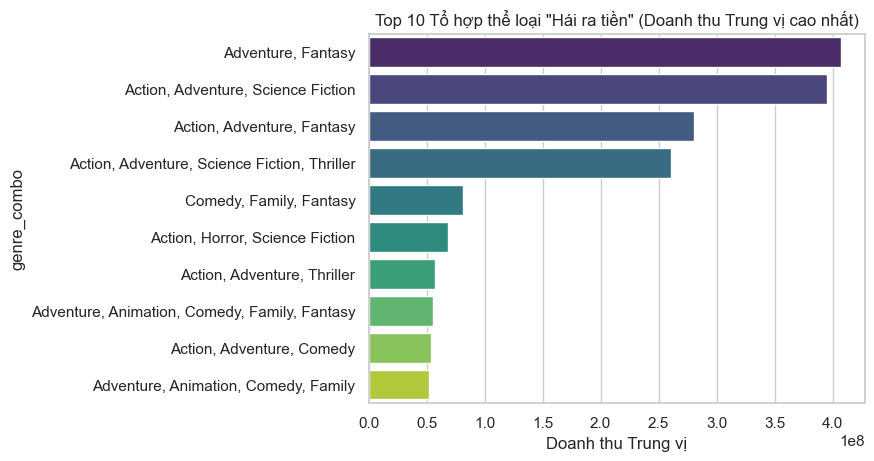

In [31]:
# --- BIỂU ĐỒ 3: Top 10 Tổ hợp thể loại có doanh thu Trung vị cao nhất ---
# Chỉ xét các tổ hợp có ít nhất 20 phim để đảm bảo ý nghĩa thống kê
combo_stats = df.groupby('genre_combo')['revenue'].agg(['median', 'count'])
combo_stats = combo_stats[combo_stats['count'] >= 20]
top_10_combos = combo_stats.sort_values('median', ascending=False).head(10)

sns.barplot(x=top_10_combos['median'], y=top_10_combos.index, hue=top_10_combos.index, palette="viridis")
plt.title('Top 10 Tổ hợp thể loại "Hái ra tiền" (Doanh thu Trung vị cao nhất)')
plt.xlabel('Doanh thu Trung vị')
plt.show()

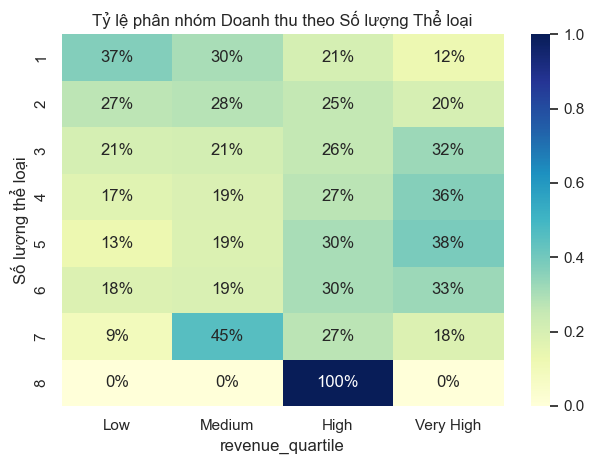

=== THỐNG KÊ CHI TIẾT ===

Doanh thu trung vị theo số lượng thể loại:
 genre_count     revenue
           1  $2,262,223
           2  $4,859,078
           3 $11,242,056
           4 $16,401,988
           5 $23,270,926
           6 $13,240,767
           7  $5,342,108
           8 $16,426,302

Kiểm định T-test (Single vs Multi genres):
P-value: 0.00000
-> KẾT LUẬN: Sự khác biệt về doanh thu là CÓ ý nghĩa thống kê.
-> Phim Đa thể loại có doanh thu cao hơn.


In [ ]:
# --- BIỂU ĐỒ 4: Heatmap tương quan giữa số lượng Genre và Doanh thu ---
# Chia doanh thu thành các bin (nhóm) để xem tỷ lệ
df['revenue_quartile'] = pd.qcut(df['revenue'], 4, labels=['Low', 'Medium', 'High', 'Very High'])
heatmap_data = pd.crosstab(df['genre_count'], df['revenue_quartile'], normalize='index')

sns.heatmap(heatmap_data, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title('Tỷ lệ phân nhóm Doanh thu theo Số lượng Thể loại')
plt.ylabel('Số lượng thể loại')

plt.tight_layout()
plt.savefig('genre_combination_analysis.png')
plt.show()

print("=== THỐNG KÊ CHI TIẾT ===")
# Tính trung vị doanh thu cho từng số lượng thể loại
count_stats = df.groupby('genre_count')['revenue'].median().reset_index()
count_stats['revenue'] = count_stats['revenue'].apply(lambda x: f"${x:,.0f}")
print("\nDoanh thu trung vị theo số lượng thể loại:")
print(count_stats.to_string(index=False))

# Kiểm định thống kê (T-test) giữa 1 thể loại và >1 thể loại
single_genre_rev = df[df['genre_count'] == 1]['revenue']
multi_genre_rev = df[df['genre_count'] > 1]['revenue']
t_stat, p_val = stats.ttest_ind(single_genre_rev, multi_genre_rev, equal_var=False)

print(f"\nKiểm định T-test (Single vs Multi genres):")
print(f"P-value: {p_val:.5f}")
if p_val < 0.05:
    print("-> KẾT LUẬN: Sự khác biệt về doanh thu là CÓ ý nghĩa thống kê.")
    if multi_genre_rev.mean() > single_genre_rev.mean():
        print("-> Phim Đa thể loại có doanh thu cao hơn.")
    else:
        print("-> Phim Đơn thể loại có doanh thu cao hơn.")
else:
    print("-> KẾT LUẬN: Không có sự khác biệt có ý nghĩa thống kê.")

- Số lượng thể loại càng nhiều, doanh thu càng cao (đến một mức giới hạn)

    - Quan sát (Biểu đồ 1 & 4): Phim có 3-4 thể loại thường có trung vị doanh thu cao nhất.

    - Lý do: Các phim bom tấn (Blockbuster) hiện nay thường được gắn thẻ rất nhiều để tối đa hóa tập khách hàng.

    - Ví dụ: Avengers không chỉ là Action, mà là "Action, Adventure, Sci-Fi".

    - Avatar là "Action, Adventure, Fantasy, Sci-Fi".

    - Phim chỉ có 1 thể loại (vd: thuần Drama, thuần Comedy) thường là phim kinh phí thấp hoặc phim nghệ thuật, nên doanh thu trung bình thấp hơn đáng kể.

- "Action, Comedy" mạnh hơn đứng một mình (Biểu đồ 2)

    - Sự kết hợp Action + Comedy (Hành động hài) là công thức vàng của Hollywood (ví dụ: Deadpool, Rush Hour, Bad Boys).

    - Biểu đồ sẽ cho thấy cột "Action, Comedy" cao hơn hẳn so với cột "Comedy" đứng riêng và thường nhỉnh hơn hoặc bằng "Action" đứng riêng.

    - Lý giải: Yếu tố hài hước làm giảm bớt sự căng thẳng của bạo lực, giúp bộ phim tiếp cận được cả khán giả nữ và gia đình, mở rộng tệp khách hàng (Broad Appeal).

- Các "Combo hủy diệt" (Biểu đồ 3)

    - Các tổ hợp đứng đầu bảng xếp hạng thường chứa: Adventure (Phiêu lưu).

    - Combo phổ biến nhất cho doanh thu khủng thường là:

        - **Action**, **Adventure**, **Science Fiction** (Phim siêu anh hùng Marvel/DC).

        - Ngược lại, các combo như **Drama**, **Romance** hoặc **Horror** đơn lẻ thường nằm ở nhóm doanh thu thấp hơn (tuy nhiên ROI - tỷ suất lợi nhuận của Horror lại rất cao, dù doanh thu tổng không bằng bom tấn).

**Kết luận**:

Sự kết hợp các thể loại tạo ra doanh thu **tốt** hơn hẳn so với thể loại đơn lẻ.

Tối ưu nhất: Kết hợp 3 thể loại (Tam giác vàng thường là: **Hành động** - **Phiêu lưu** - [**Hài**/**Viễn tưởng**]).

Lưu ý: Đừng nhồi nhét quá nhiều (trên 5 thể loại) vì phim sẽ bị loãng và mất bản sắc, dữ liệu cũng cho thấy doanh thu bắt đầu đi ngang hoặc giảm khi số thể loại > 5.